Data types after encoding:
year                                               int64
population                                       float64
gdp                                              float64
electricity_demand                               float64
electricity_generation                           float64
electricity_share_energy                         float64
energy_cons_change_twh                           float64
energy_per_capita                                float64
energy_per_gdp                                   float64
solar_consumption                                float64
wind_consumption                                 float64
biofuel_consumption                              float64
biofuel_electricity                              float64
hydro_electricity                                float64
solar_electricity                                float64
wind_electricity                                 float64
solar_cons_change_twh                            float64
wind

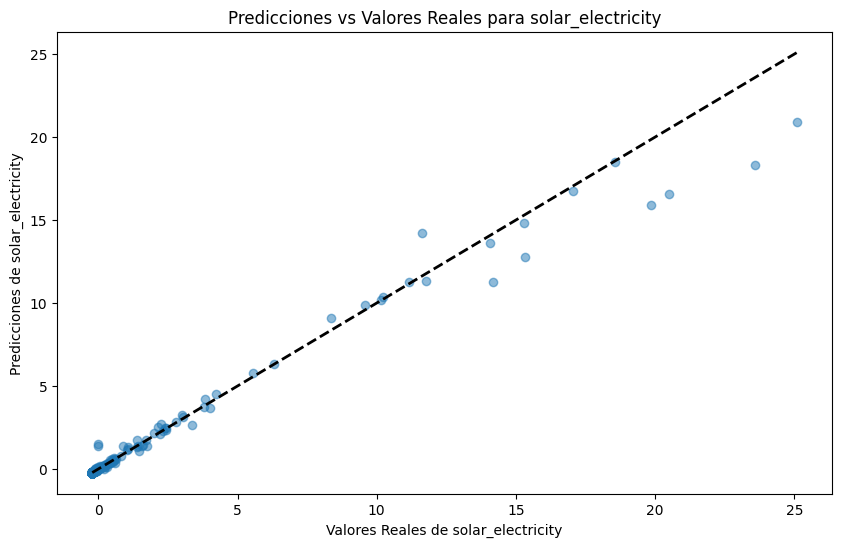

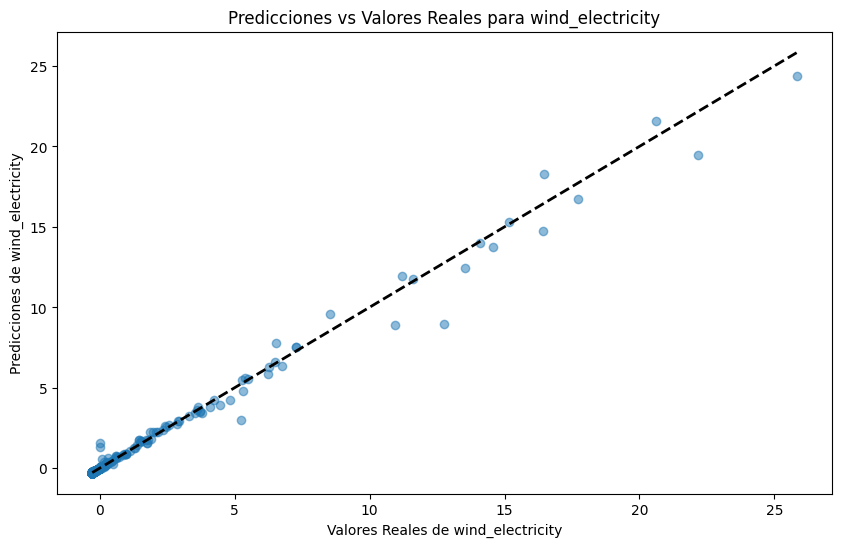

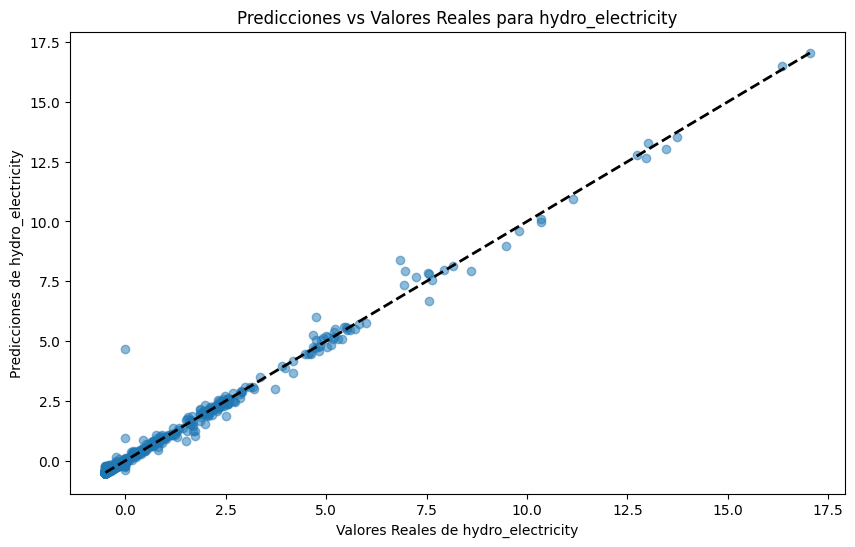

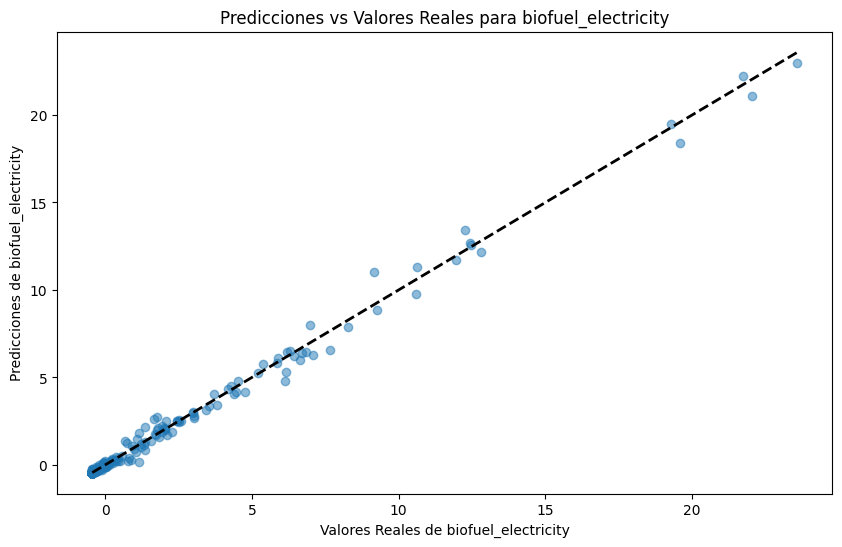

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from functions2 import load_and_clean_data

# Configurar Pandas para mostrar todos los resultados
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1. Cargar y limpiar los datos
df = load_and_clean_data('data/raw/owid-energy-data.csv')

# 2. Identificar columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# 3. Aplicar Label Encoding a las columnas categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4. Separar características y variables objetivo
# Aquí asumo que las variables objetivo son las energías renovables. Ajusta según tus datos.
target_columns = ['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']
X = df.drop(columns=target_columns)
y = df[target_columns]

# 5. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Definir el modelo
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))

# 7. Entrenar el modelo
model.fit(X_train, y_train)

# 8. Realizar predicciones
y_pred = pd.DataFrame(model.predict(X_test), columns=target_columns)

# Mostrar las predicciones completas
print("Predicciones completas:")
print(y_pred)

# 9. Comparar las predicciones con los valores reales mediante gráficas
for col in target_columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test[col], y_pred[col], alpha=0.5)
    plt.plot([y_test[col].min(), y_test[col].max()], [y_test[col].min(), y_test[col].max()], 'k--', lw=2)
    plt.xlabel(f"Valores Reales de {col}")
    plt.ylabel(f"Predicciones de {col}")
    plt.title(f"Predicciones vs Valores Reales para {col}")
    plt.show()



Top 10 características más importantes:
                        Importance
solar_consumption         0.345577
electricity_generation    0.186006
electricity_demand        0.153073
solar_share_elec          0.120360
solar_cons_change_twh     0.065286
year                      0.056889
wind_share_elec           0.028208
wind_cons_change_twh      0.008919
wind_consumption          0.006240
population                0.004753


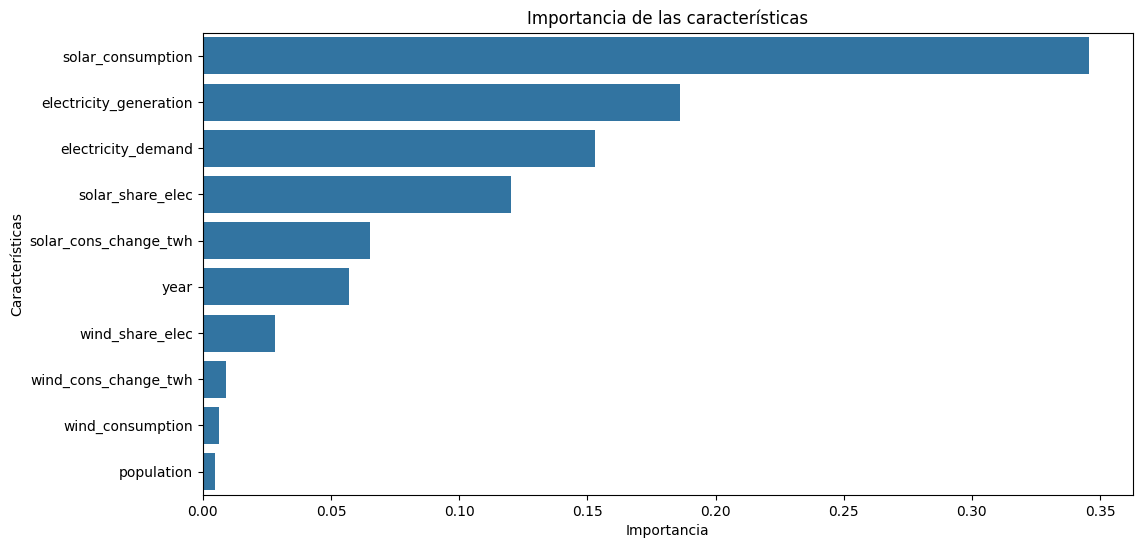

In [3]:
import numpy as np

# Obtener las importancias de las características
importances = model.estimators_[0].feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"]).sort_values("Importance", ascending=False)

# Mostrar las 10 características más importantes
print("Top 10 características más importantes:")
print(feature_importances.head(10))

# Graficar la importancia de las características
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances["Importance"].head(10), y=feature_importances.index[:10])
plt.title("Importancia de las características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()


In [4]:
# Seleccionar características importantes
important_threshold = 0.01
selected_features = feature_importances[feature_importances["Importance"] > important_threshold].index.tolist()

# Crear nuevo DataFrame con características seleccionadas
X_selected = X[selected_features]


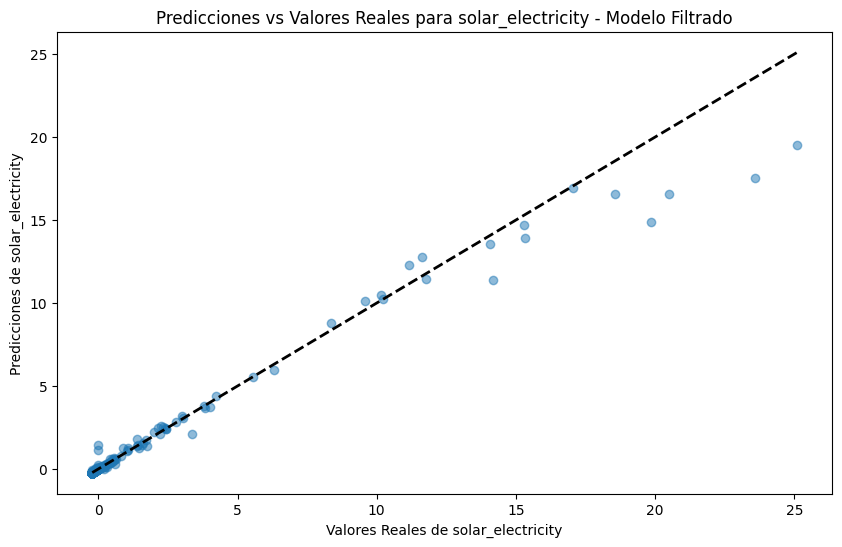

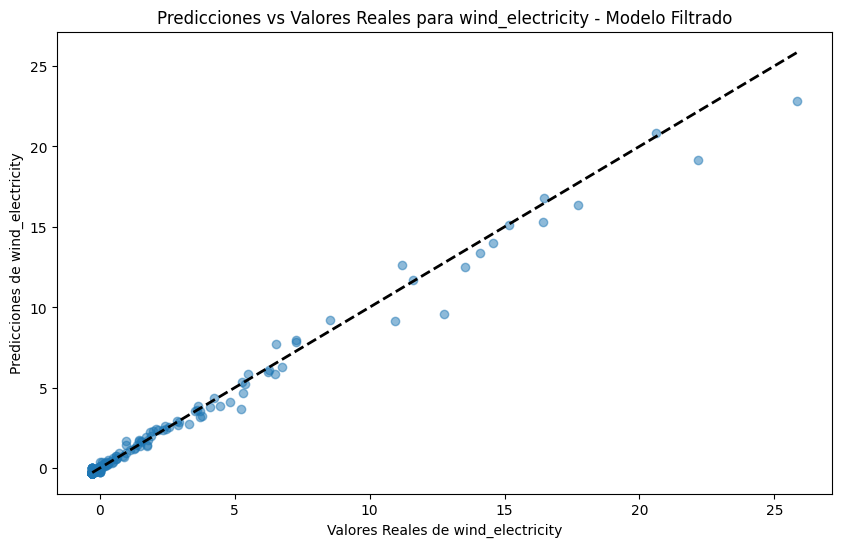

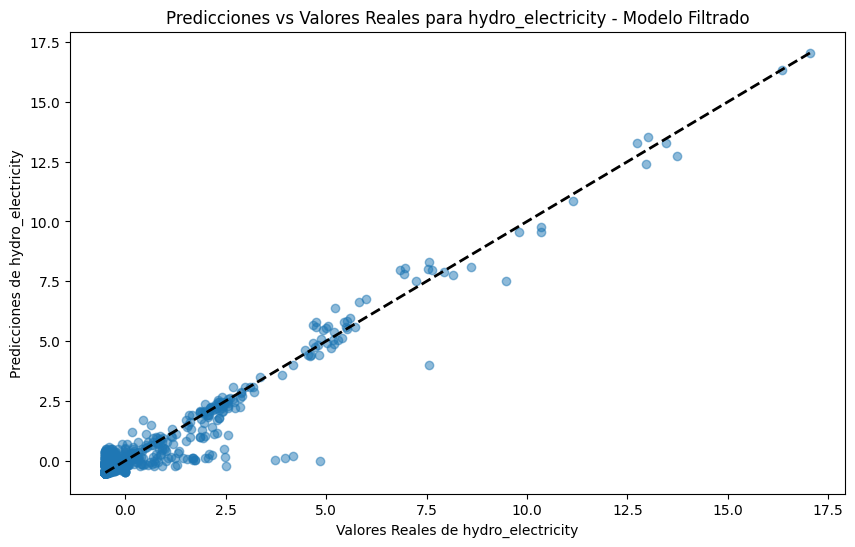

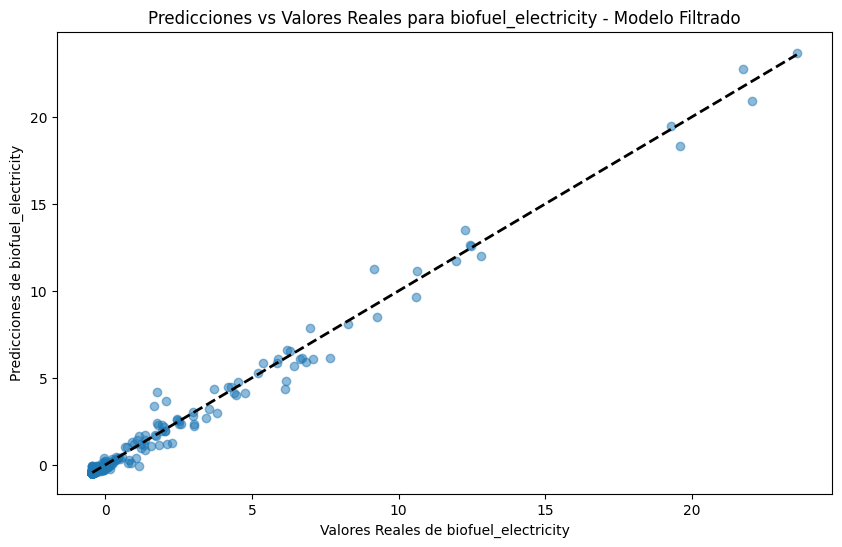

In [5]:
# Dividir los datos nuevamente
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Definir el modelo nuevamente
model_selected = MultiOutputRegressor(RandomForestRegressor())

# Entrenar el modelo
model_selected.fit(X_train_selected, y_train)

# Hacer predicciones
y_pred_selected = pd.DataFrame(model_selected.predict(X_test_selected), columns=target_columns)

# Comparar con valores reales
for col in target_columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test[col], y_pred_selected[col], alpha=0.5)
    plt.plot([y_test[col].min(), y_test[col].max()], [y_test[col].min(), y_test[col].max()], 'k--', lw=2)
    plt.xlabel(f"Valores Reales de {col}")
    plt.ylabel(f"Predicciones de {col}")
    plt.title(f"Predicciones vs Valores Reales para {col} - Modelo Filtrado")
    plt.show()


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular métricas de rendimiento
mae = mean_absolute_error(y_test, y_pred_selected)
rmse = mean_squared_error(y_test, y_pred_selected, squared=False)
r2 = r2_score(y_test, y_pred_selected)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")


MAE: 0.03, RMSE: 0.16, R²: 0.97


c:\Users\Carlos\.ai-navigator\conda\envs\ml-project\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
mae_cv = -cv_scores.mean()

print(f"MAE (Validación Cruzada): {mae_cv:.4f}")


MAE (Validación Cruzada): 0.0439


In [8]:
from sklearn.model_selection import GridSearchCV

# Definir el espacio de hiperparámetros para Random Forest
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print(f"MAE (Mejor Modelo): {-grid_search.best_score_:.4f}")


Mejores parámetros: {'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
MAE (Mejor Modelo): 0.0138


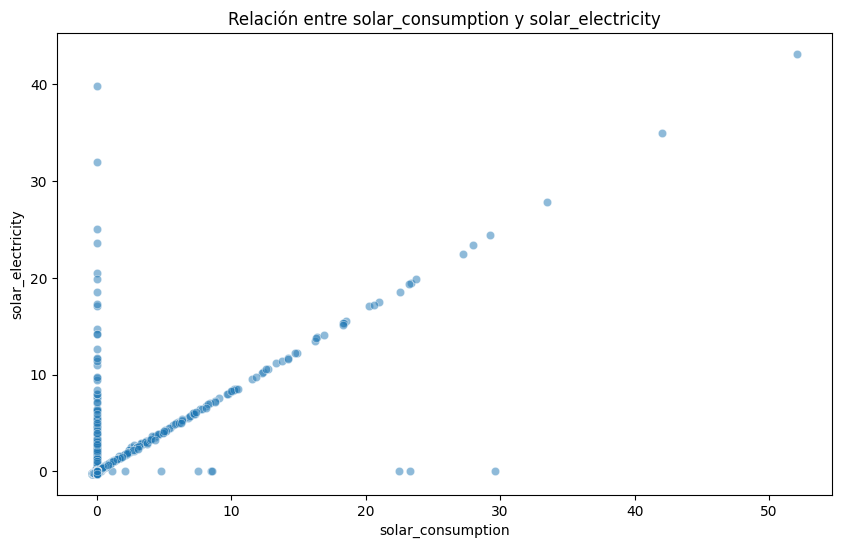

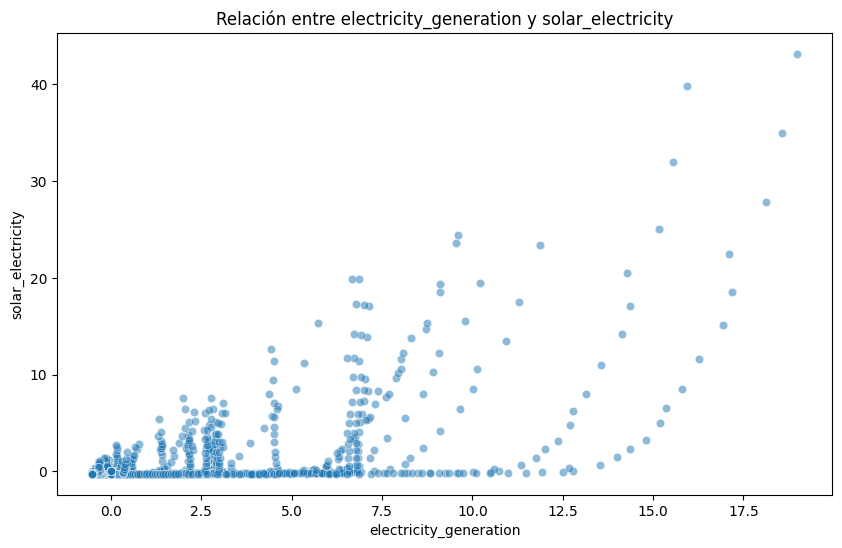

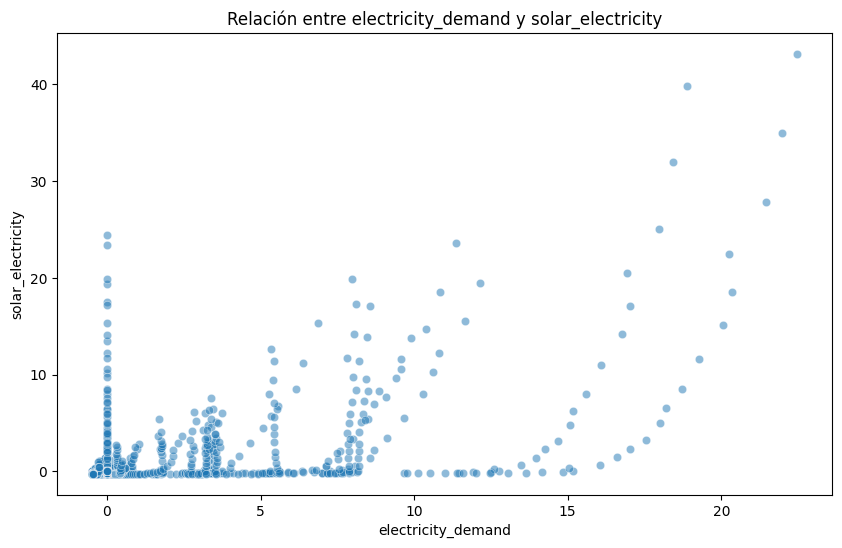

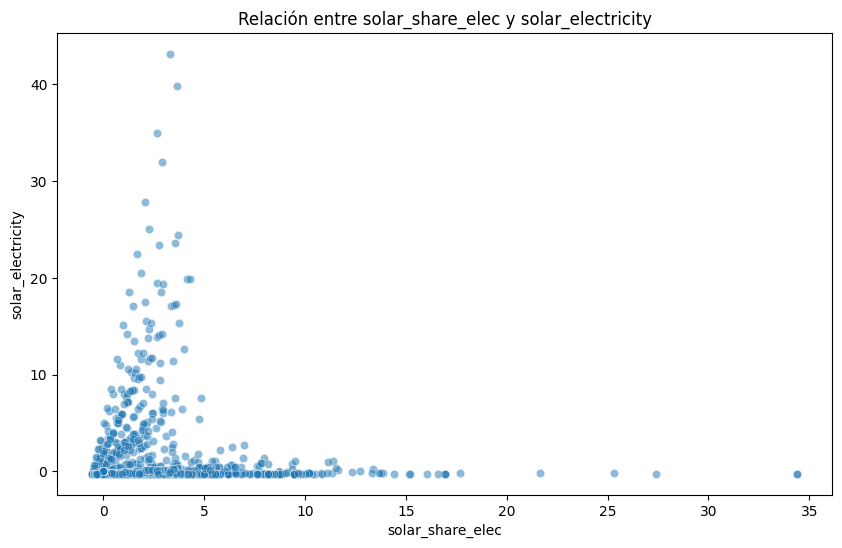

In [9]:
# Visualización de las variables más importantes
import seaborn as sns

top_features = ['solar_consumption', 'electricity_generation', 'electricity_demand', 'solar_share_elec']
for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[feature], y=df['solar_electricity'], alpha=0.5)
    plt.title(f"Relación entre {feature} y solar_electricity")
    plt.xlabel(feature)
    plt.ylabel('solar_electricity')
    plt.show()


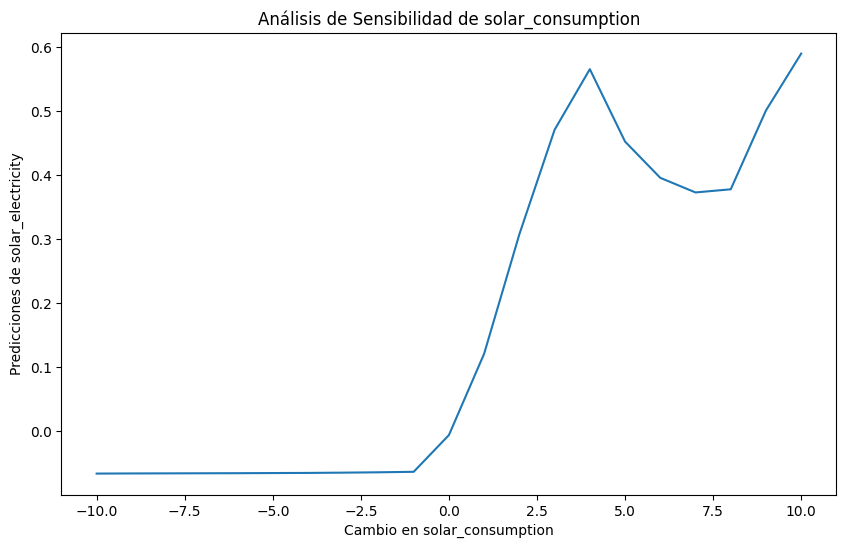

In [10]:
# Ejemplo de análisis de sensibilidad: variar solar_consumption
sensitivity_analysis = []
for change in range(-10, 11, 1):  # Varia de -10 a +10
    altered_data = X_test.copy()
    altered_data['solar_consumption'] += change  # Ajustar la variable
    predictions = model.predict(altered_data)
    sensitivity_analysis.append(predictions.mean())

plt.figure(figsize=(10, 6))
plt.plot(range(-10, 11, 1), sensitivity_analysis)
plt.title('Análisis de Sensibilidad de solar_consumption')
plt.xlabel('Cambio en solar_consumption')
plt.ylabel('Predicciones de solar_electricity')
plt.show()


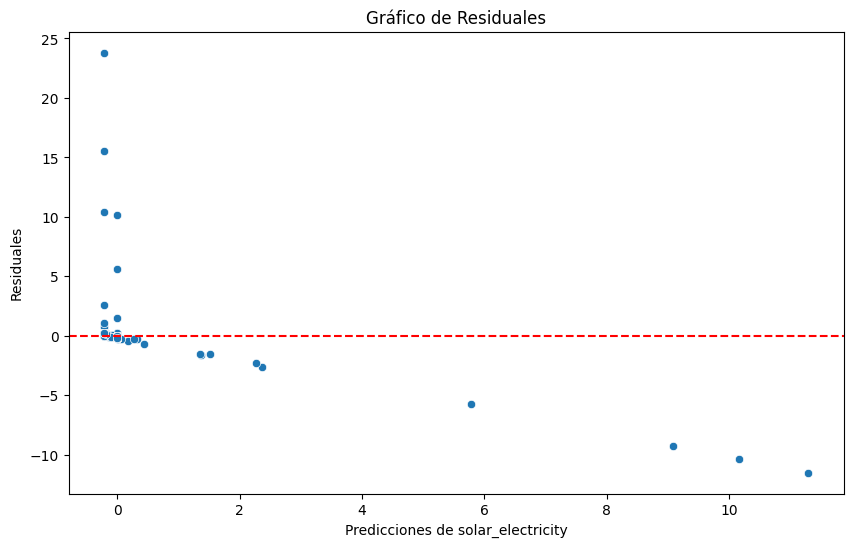

In [11]:
# Gráfico de residuales
residuals = y_test['solar_electricity'] - y_pred['solar_electricity']

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred['solar_electricity'], y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Gráfico de Residuales')
plt.xlabel('Predicciones de solar_electricity')
plt.ylabel('Residuales')
plt.show()


In [14]:
from joblib import dump

# Guardar el modelo
dump(model_selected, 'model/random_forest_seap.joblib')

# Guardar los nombres de las características usadas durante el entrenamiento
features = X_train.columns.tolist()  # Obtener las columnas del conjunto de entrenamiento
dump(features, 'model/feature_names.joblib')  # Guardar las características
# Guardar las columnas utilizadas para el modelo
features_filepath = 'model/features.txt'
with open(features_filepath, 'w') as f:
    for column in X.columns:
        f.write(f"{column}\n")


In [15]:
print("Training Features:", features)  # The features used during training
print("Test Features:", X_test.columns)  # The features in the test set


Training Features: ['year', 'population', 'gdp', 'electricity_demand', 'electricity_generation', 'electricity_share_energy', 'energy_cons_change_twh', 'energy_per_capita', 'energy_per_gdp', 'solar_consumption', 'wind_consumption', 'biofuel_consumption', 'solar_cons_change_twh', 'wind_cons_change_twh', 'biofuel_cons_change_pct', 'solar_share_elec', 'wind_share_elec', 'country_Afghanistan', 'country_Africa', 'country_Africa (EI)', 'country_Africa (EIA)', 'country_Africa (Ember)', 'country_Africa (Shift)', 'country_Albania', 'country_Algeria', 'country_American Samoa', 'country_Angola', 'country_Antarctica', 'country_Antigua and Barbuda', 'country_Argentina', 'country_Armenia', 'country_Aruba', 'country_Asia', 'country_Asia & Oceania (EIA)', 'country_Asia (Ember)', 'country_Asia Pacific (EI)', 'country_Asia and Oceania (Shift)', 'country_Australia', 'country_Australia and New Zealand (EIA)', 'country_Austria', 'country_Azerbaijan', 'country_Bahamas', 'country_Bahrain', 'country_Bangladesh

In [16]:
# Mostrar las columnas que se usaron durante el entrenamiento del modelo
print("Features used during training:")
print(X_train.columns.tolist())


Features used during training:
['year', 'population', 'gdp', 'electricity_demand', 'electricity_generation', 'electricity_share_energy', 'energy_cons_change_twh', 'energy_per_capita', 'energy_per_gdp', 'solar_consumption', 'wind_consumption', 'biofuel_consumption', 'solar_cons_change_twh', 'wind_cons_change_twh', 'biofuel_cons_change_pct', 'solar_share_elec', 'wind_share_elec', 'country_Afghanistan', 'country_Africa', 'country_Africa (EI)', 'country_Africa (EIA)', 'country_Africa (Ember)', 'country_Africa (Shift)', 'country_Albania', 'country_Algeria', 'country_American Samoa', 'country_Angola', 'country_Antarctica', 'country_Antigua and Barbuda', 'country_Argentina', 'country_Armenia', 'country_Aruba', 'country_Asia', 'country_Asia & Oceania (EIA)', 'country_Asia (Ember)', 'country_Asia Pacific (EI)', 'country_Asia and Oceania (Shift)', 'country_Australia', 'country_Australia and New Zealand (EIA)', 'country_Austria', 'country_Azerbaijan', 'country_Bahamas', 'country_Bahrain', 'countr